In [ ]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from math import floor
from termcolor import colored as cl

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
sq_1d = yf.download(tickers='SQ', start='2015-11-29', end = '2021-08-11', interval='1d')
sq_1d .drop(columns = ['Adj Close'], inplace = True)
sq_1d .reset_index(inplace = True)
sq_1d .rename(columns = {'index' : "Date"}, inplace = True)
sq_1d .set_index(pd.to_datetime(sq_1d ['Date'], infer_datetime_format=True), inplace=True)
sq_1d .drop(columns = 'Date', inplace = True)
sq_1d 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-11-30,12.280000,12.350000,11.900000,12.040000,1997100
2015-12-01,12.120000,12.180000,11.890000,11.910000,1256100
2015-12-02,11.970000,12.155000,11.900000,11.930000,1708100
2015-12-03,12.040000,12.250000,11.910000,11.920000,1431400
2015-12-04,11.950000,12.040000,11.800000,12.040000,1331600
...,...,...,...,...,...
2021-08-04,268.000000,268.390015,261.000000,266.420013,10241400
2021-08-05,265.600006,289.230011,264.769989,281.809998,19413700
2021-08-06,279.510010,285.859985,273.100006,275.100006,9482100


In [ ]:
def sma(price, period):
    sma = price.rolling(period).mean()
    return sma

def ao(price, period1, period2):
    median = price.rolling(2).median()
    short = sma(median, period1)
    long = sma(median, period2)
    ao = short - long
    ao_df = pd.DataFrame(ao).rename(columns = {'Close':'ao'})
    return ao_df

sq_1d['ao'] = ao(sq_1d['Close'], 5, 34)
sq_1d = sq_1d.dropna()
sq_1d.tail()

,Open,High,Low,Close,Volume,ao
Date,,,,,,
2021-08-04,268.000000,268.390015,261.000000,266.420013,10241400,14.969557
2021-08-05,265.600006,289.230011,264.769989,281.809998,19413700,17.124295
2021-08-06,279.510010,285.859985,273.100006,275.100006,9482100,21.329973
2021-08-09,272.989990,286.519989,270.630005,279.730011,10561700,23.615298
2021-08-10,280.010010,283.589996,272.640015,273.079987,6694800,23.489445


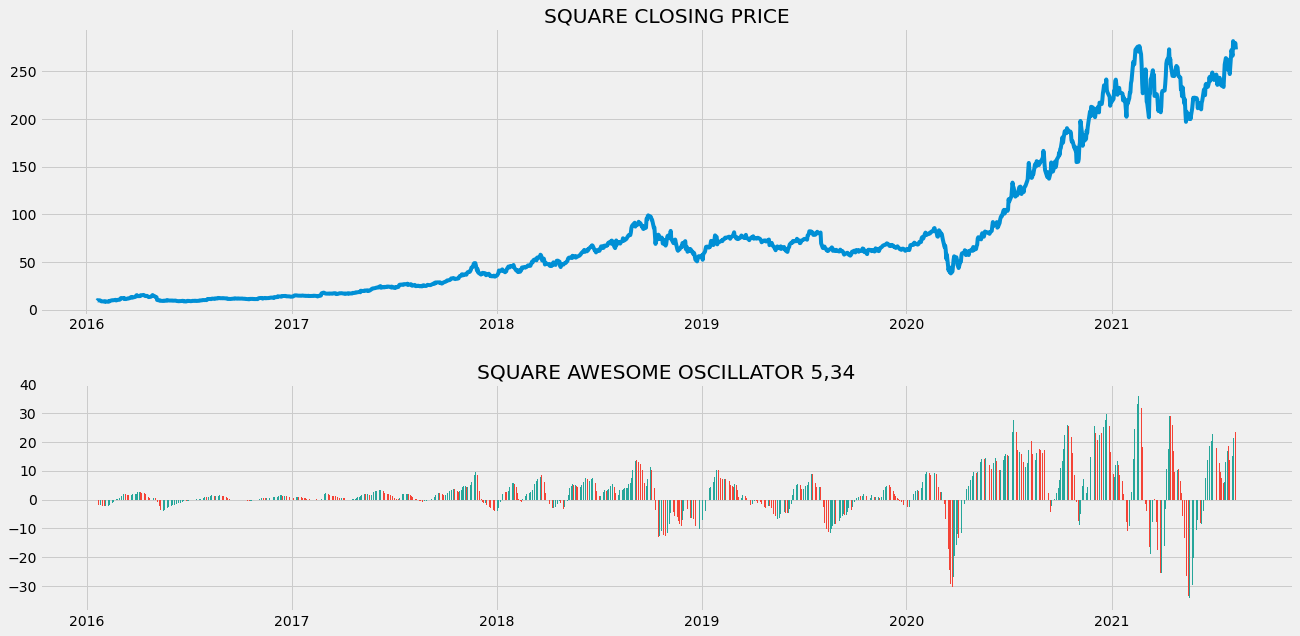

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(sq_1d['Close'])
ax1.set_title('SQUARE CLOSING PRICE')
for i in range(len(sq_1d)):
    if sq_1d['ao'][i-1] > sq_1d['ao'][i]:
        ax2.bar(sq_1d.index[i], sq_1d['ao'][i], color = '#f44336')
    else:
        ax2.bar(sq_1d.index[i], sq_1d['ao'][i], color = '#26a69a')
ax2.set_title('SQUARE AWESOME OSCILLATOR 5,34')
plt.show()

In [ ]:
def implement_ao_crossover(price, ao):
    buy_price = []
    sell_price = []
    ao_signal = []
    signal = 0
    
    for i in range(len(ao)):
        if ao[i] > 0 and ao[i-1] < 0:
            if signal != 1:
                buy_price.append(price[i])
                sell_price.append(np.nan)
                signal = 1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        elif ao[i] < 0 and ao[i-1] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(price[i])
                signal = -1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ao_signal.append(0)
    return buy_price, sell_price, ao_signal

buy_price, sell_price, ao_signal = implement_ao_crossover(sq_1d['Close'], sq_1d['ao'])

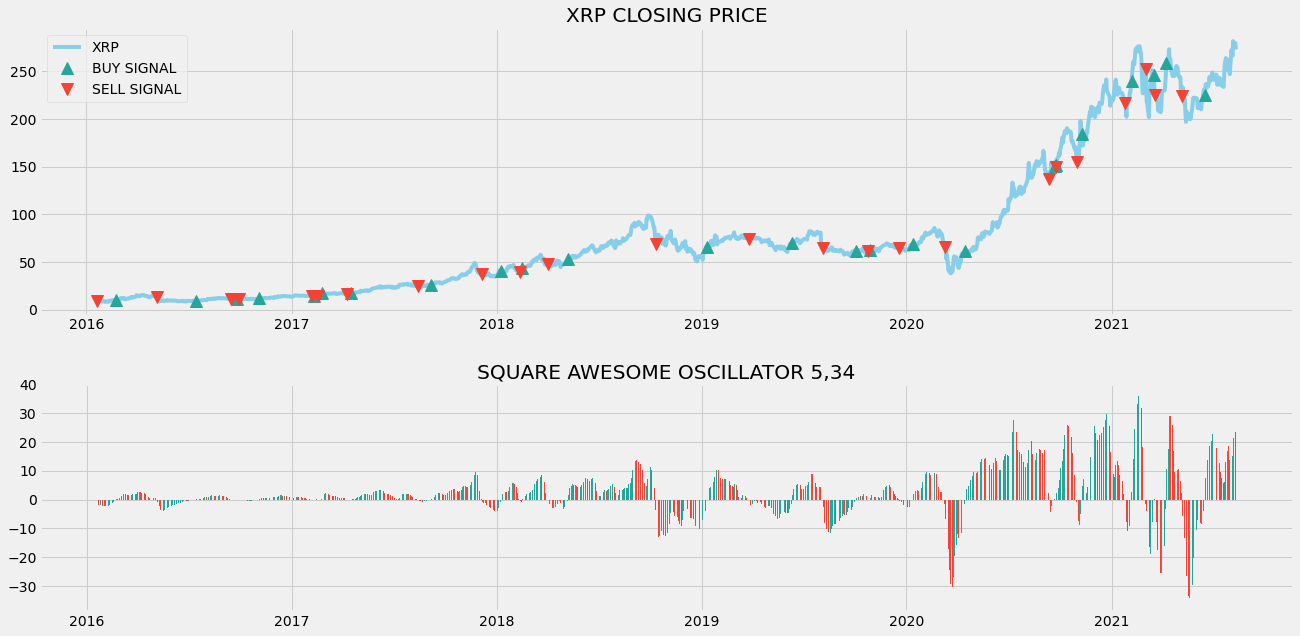

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(sq_1d['Close'], label = 'XRP', color = 'skyblue')
ax1.plot(sq_1d.index, buy_price, marker = '^', markersize = 12, color = '#26a69a', linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(sq_1d.index, sell_price, marker = 'v', markersize = 12, color = '#f44336', linewidth = 0, label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('XRP CLOSING PRICE')
for i in range(len(sq_1d)):
    if sq_1d['ao'][i-1] > sq_1d['ao'][i]:
        ax2.bar(sq_1d.index[i], sq_1d['ao'][i], color = '#f44336')
    else:
        ax2.bar(sq_1d.index[i], sq_1d['ao'][i], color = '#26a69a')
ax2.set_title('SQUARE AWESOME OSCILLATOR 5,34')
plt.show()

In [ ]:
position = []
for i in range(len(ao_signal)):
    if ao_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(sq_1d['Close'])):
    if ao_signal[i] == 1:
        position[i] = 1
    elif ao_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
ao = sq_1d['ao']
close_price = sq_1d['Close']
ao_signal = pd.DataFrame(ao_signal).rename(columns = {0:'ao_signal'}).set_index(sq_1d.index)
position = pd.DataFrame(position).rename(columns = {0:'ao_position'}).set_index(sq_1d.index)

frames = [close_price, ao, ao_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,ao,ao_signal,ao_position
Date,,,,
2016-01-20,9.490000,-1.342265,-1,0
2016-01-21,10.020000,-1.695971,0,0
2016-01-22,9.850000,-1.893588,0,0
2016-01-25,9.810000,-1.974970,0,0
2016-01-26,9.540000,-1.946176,0,0
...,...,...,...,...
2021-08-04,266.420013,14.969557,0,1
2021-08-05,281.809998,17.124295,0,1
2021-08-06,275.100006,21.329973,0,1


In [ ]:
sq_ret = pd.DataFrame(np.diff(sq_1d['Close'])).rename(columns = {0:'returns'})
ao_strategy_ret = []

for i in range(len(sq_ret)):
    returns = sq_ret['returns'][i]*strategy['ao_position'][i]
    ao_strategy_ret.append(returns)
    
ao_strategy_ret_df = pd.DataFrame(ao_strategy_ret).rename(columns = {0:'ao_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/sq_1d['Close'][-1])
ao_investment_ret = []

for i in range(len(ao_strategy_ret_df['ao_returns'])):
    returns = number_of_stocks*ao_strategy_ret_df['ao_returns'][i]
    ao_investment_ret.append(returns)

ao_investment_ret_df = pd.DataFrame(ao_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(ao_investment_ret_df['investment_returns']), 2)
profit_percentage = round((total_investment_ret/investment_value)*100, 2)
print(cl('Profit gained from the AO strategy by investing $100k in SQ : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the AO strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the AO strategy by investing $100k in SQ : 58098.84
Profit percentage of the AO strategy : 58.1%


In [ ]:
strategy.to_csv('SQ 1D AO TRADE STRATEGY.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>